# Inference using a prior trained model on a new dataset

Where a model has already been trained, it can then be used to assist with classifications basd opn previously unseen data. This is a simple example of loading and applying a prior trained model to a csv dataset.

A dataset is provided for demonstrating this implementation - [sample_derivatives_for_inference.csv](./example_data/sample_derivatives_for_inference.csv)

In [1]:
import os
import sys
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
import h2o 
from pathlib import Path
sys.path.append("../../")
from rf_classifier import data_processing, h2o_rf, plotting

# Your prior trained model - look for the name generated from the previous script 01_rf-train-and-test.ipynb 
# This number will differ to your model output so change accordingly
MODEL_PATH = "RFClassifier_h2o/DRF_model_python_1692614774280_1" 

INPUT_DATA= 'example_data/sample_derivatives_for_inference.csv'

OUT_DIR="./predictions"
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
OFILE= '%s/my_predictions.csv' %(OUT_DIR)

Start and h2o instance and get the pre trained model loaded...

In [2]:
try:
    h2o.cluster().shutdown()
except:
    print("No session to shutdown...")
h2o.init()
rf = h2o.load_model(MODEL_PATH)

No session to shutdown...
Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,2 mins 53 secs
H2O_cluster_timezone:,Europe/London
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.2
H2O_cluster_version_age:,9 months and 24 days !!!
H2O_cluster_name:,H2O_from_python_chrwil_2n1ewk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.435 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Now read in the data and look at the columns

In [3]:
new_observations = pd.read_csv(INPUT_DATA, encoding="ISO-8859-1", na_values=['NA',-9999], low_memory=False)
[print(c) for c in new_observations.columns];

x
y
elevation
conv_k3
mrrtf_t42
mrvbf_t42
aspect
easterness
fishersK_k3
fishersK_k5
fishersK_k7
fishersK_k9
geomorphons
grass_aspect
grass_pcurve
grass_slope
grass_tcurve
northerness
northerness_slope
slope
stdDev_k3
stdDev_k5
stdDev_k7
stdDev_k9
topoRoughIdx_k3
topoRoughIdx_k5
topoRoughIdx_k7
topoRoughIdx_k9
topoWetIdx
vector_strength_k3
vector_strength_k5
vector_strength_k7
vector_strength_k9


In [4]:
X_COL="x"
Y_COL="y"
RESCALE_DATA = True #doesnt matter for RF but helps with scatterplots and data validation
DIRECTIONAL_VARIABLES = ['aspect',
                         'grass_aspect'] #list of variables defined as compass degrees - the be retyped as categoricals

# Drop any unnecessary columns
DATA_DROPS = [] # add any columns you want to drop here....
for f in DATA_DROPS:
    new_observations = new_observations.drop(f, axis = 1)

#Re-format compass point variables (degress to categories - N,S,E,W etc.)
for f in DIRECTIONAL_VARIABLES:
    new_observations[f] = data_processing.categorize_aspect(new_observations[f])
    
if(RESCALE_DATA):
    new_observations = data_processing.rescale_data(new_observations, '')

******************
elevation 

Before rescaling:
Min:  -431.725204223633
Max:  3.34140039062504

After rescaling:
Min:  [0.]
Max:  [1.]
******************
******************
conv_k3 

Before rescaling:
Min:  -68.2974319458008
Max:  53.0265350341797

After rescaling:
Min:  [0.]
Max:  [1.]
******************
******************
mrrtf_t42 

Before rescaling:
Min:  1.0961453966729099e-11
Max:  4.77715974998653

After rescaling:
Min:  [0.]
Max:  [1.]
******************
******************
mrvbf_t42 

Before rescaling:
Min:  1.44765088805343e-10
Max:  4.96979718763035

After rescaling:
Min:  [0.]
Max:  [1.]
******************
******************
easterness 

Before rescaling:
Min:  -0.999999523162842
Max:  0.999981939792633

After rescaling:
Min:  [0.]
Max:  [1.]
******************
******************
fishersK_k3 

Before rescaling:
Min:  0.0
Max:  1.04414510726929

After rescaling:
Min:  [0.]
Max:  [1.]
******************
******************
fishersK_k5 

Before rescaling:
Min:  0.0
Max:  0.9529

In [5]:
# Drop any rows with NA
while new_observations.isnull().values.any():
    new_observations.dropna(inplace = True)

if not new_observations.isnull().values.any():
    print("No NaNs in dataframe")

No NaNs in dataframe


Double check dataset columns after clean up...

In [6]:
[print(c) for c in new_observations.columns];

x
y
elevation
conv_k3
mrrtf_t42
mrvbf_t42
aspect
easterness
fishersK_k3
fishersK_k5
fishersK_k7
fishersK_k9
geomorphons
grass_aspect
grass_pcurve
grass_slope
grass_tcurve
northerness
northerness_slope
slope
stdDev_k3
stdDev_k5
stdDev_k7
stdDev_k9
topoRoughIdx_k3
topoRoughIdx_k5
topoRoughIdx_k7
topoRoughIdx_k9
topoWetIdx
vector_strength_k3
vector_strength_k5
vector_strength_k7
vector_strength_k9


## Inference stage

Now the data are sorted, let's pass them to the model...

In [7]:
#predict on new data
new_observations = h2o.H2OFrame(new_observations) # adds the input data as an h2o object
new_predictions = rf.predict(new_observations)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


We'll now look at the outputs...

In [8]:
# Get the H2o frame s a local object
new_predictions=new_predictions.as_data_frame()

In [9]:
print(new_predictions.head())
print(new_predictions.tail())
print(new_predictions['p0'].min())
print(new_predictions['p0'].max())
print(new_predictions['p1'].min())
print(new_predictions['p1'].max())
new_predictions['predict'].unique() # unique predicted values (should be 1 and 0)

   predict        p0        p1
0        0  0.571415  0.428585
1        0  0.581967  0.418033
2        0  0.603428  0.396572
3        0  0.590655  0.409345
4        0  0.525065  0.474935
      predict        p0        p1
2081        0  0.562614  0.437386
2082        0  0.549145  0.450855
2083        0  0.588598  0.411402
2084        0  0.524275  0.475725
2085        0  0.579717  0.420283
0.479345935851665
0.6858922015791065
0.3141077984208936
0.520654064148335


array([0, 1], dtype=int64)

Now append the predicted values to the input dataframe

In [10]:
# get obs bck as local object
new_observations=new_observations.as_data_frame()

In [11]:
new_predictions.columns

Index(['predict', 'p0', 'p1'], dtype='object')

In [12]:
new_observations['predict']=new_predictions['predict'] # model's predicted classificiation
new_observations['p1']=new_predictions['p1'] # append column for probability of being a 1
new_observations['p0']=new_predictions['p0'] # append column for probability of being a 0

Look at the output dataframe...

In [13]:
[print(c) for c in new_observations.columns];

x
y
elevation
conv_k3
mrrtf_t42
mrvbf_t42
aspect
easterness
fishersK_k3
fishersK_k5
fishersK_k7
fishersK_k9
geomorphons
grass_aspect
grass_pcurve
grass_slope
grass_tcurve
northerness
northerness_slope
slope
stdDev_k3
stdDev_k5
stdDev_k7
stdDev_k9
topoRoughIdx_k3
topoRoughIdx_k5
topoRoughIdx_k7
topoRoughIdx_k9
topoWetIdx
vector_strength_k3
vector_strength_k5
vector_strength_k7
vector_strength_k9
predict
p1
p0


Write dataframe to csv...

In [14]:
new_observations.to_csv(OFILE, index=False)
print("Output written to %s" %OFILE)

Output written to ./predictions/my_predictions.csv


## Plotting...

Text(0, 0.5, 'y')

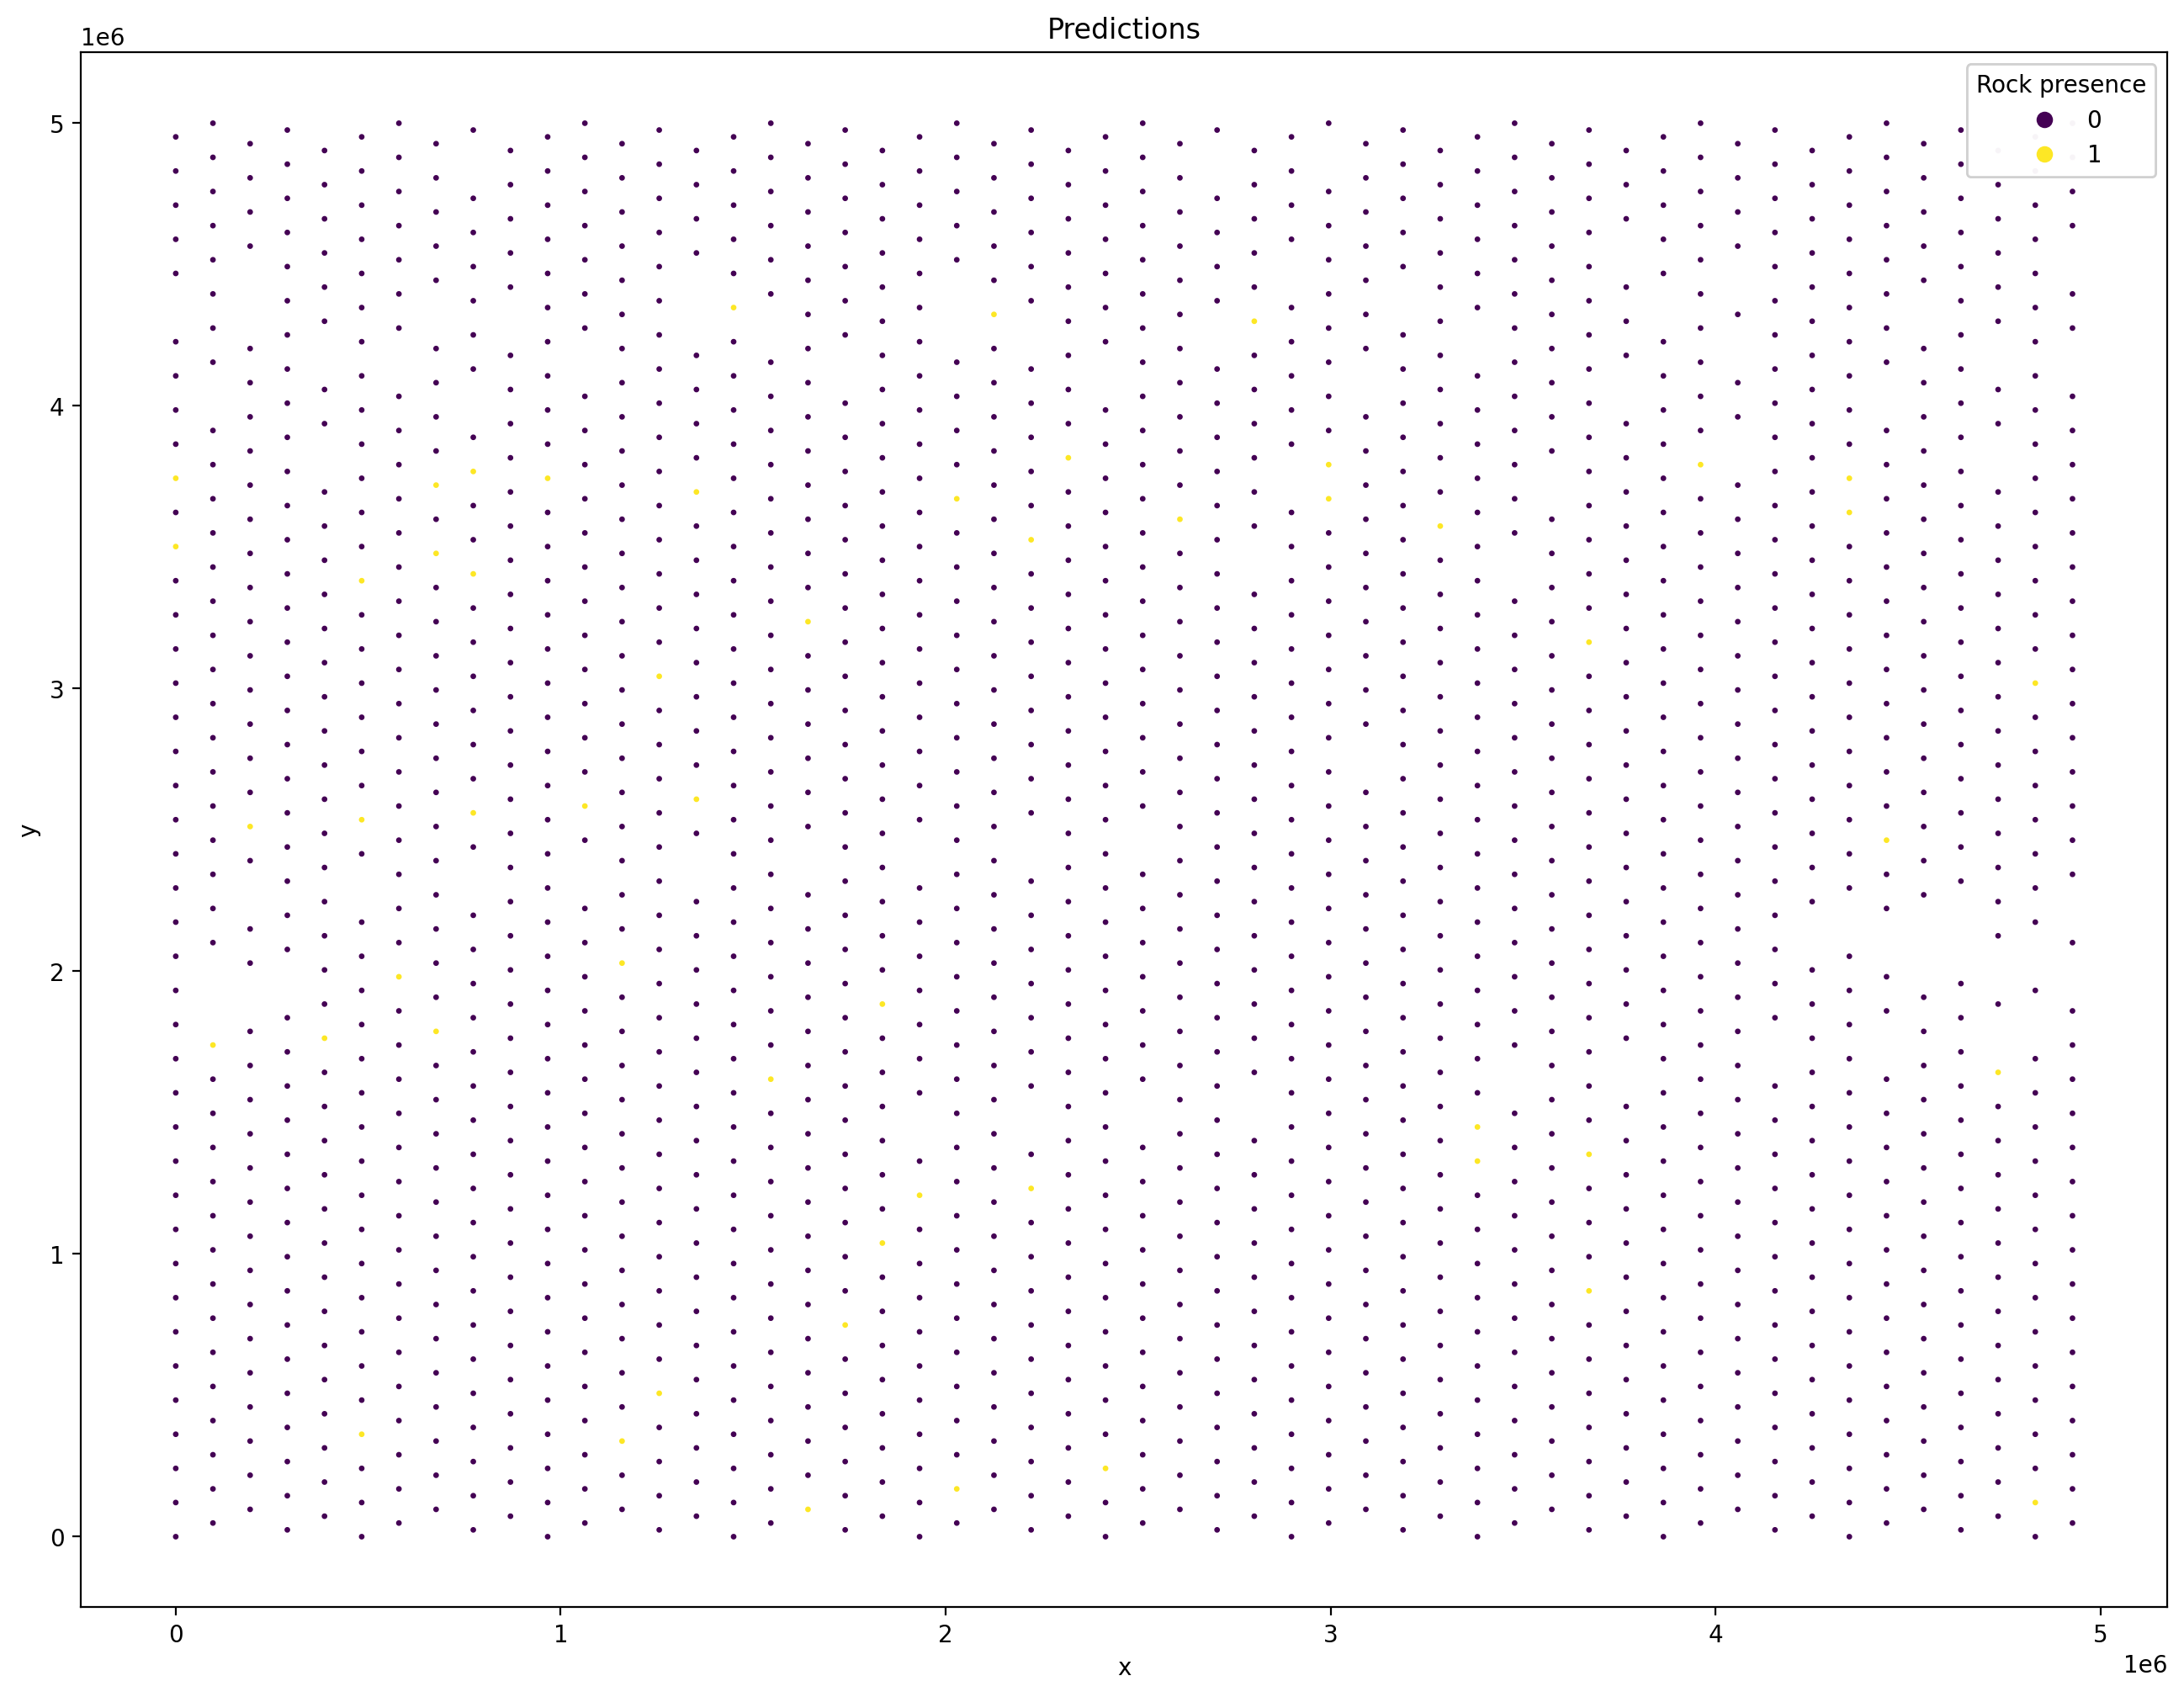

In [15]:
fig, ax = plt.subplots(figsize=(16, 12), dpi=200)

scatter = ax.scatter(new_observations[X_COL], new_observations[Y_COL], 
                     c = new_observations['predict'], s = 2,
                     cmap=mpl.colormaps['viridis'])

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Rock presence",prop={'size': 10})

ax.add_artist(legend1)
ax.set_title('Predictions')
ax.set_xlabel('x')
ax.set_ylabel('y')


Clear and close H2O

In [16]:
h2o.cluster().shutdown()

H2O session _sid_9473 closed.


## Predicting over large datasets *for reference*

Following was used for predicting over a very large dataset that was split based on `BATCH_SIZE` (number of rows in the `new_observations` (called `inference_data`).

There is also some additional output data manipulation also left for info.

```python
for i in range(len(inference_data) // BATCH_SIZE):
    
    data_batch = inference_data[i * BATCH_SIZE: (i+1)* BATCH_SIZE]

    if (RESCALE_DATA):
        data_batch = data_processing.rescale_data(data_batch, DEPENDENT_COLUMN, X_COL, Y_COL)

    unknowns = h2o.H2OFrame(data_batch)
    unknowns['Productivi'] = unknowns['Productivi'].asnumeric()
    predictions = rf.predict(unknowns)

    predictions = h2o.as_list(predictions)

    unknowns = h2o.as_list(unknowns)
    unknowns['predict'] = predictions['predict']
    unknowns['p1_prob'] = predictions['p1']
    unknowns['thresholded_p1'] = unknowns['p1_prob']-(THRESHOLD-0.5)
    unknowns['thresholded_predict'] = round(unknowns['thresholded_p1']).astype(int)
    
    #save predictions dataframe
    unknowns.to_csv(RESULTS_PATH, mode = 'a', header = not os.path.exists(RESULTS_PATH))


    if PLOT:
        plt.figure(figsize=(16, 12), dpi=80)
        plt.scatter(unknowns[X_COL], unknowns[Y_COL], c = unknowns['p1_prob'],s = 2)

        plt.title('confidence of dependent variable = 1')
            #plt.legend()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()



        plt.figure(figsize=(16, 12), dpi=80)
        plt.scatter(unknowns[X_COL], unknowns[Y_COL], c = unknowns['thresholded_predict'],s = 2)

        plt.title('Predictions')
        plt.legend()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()
        h2o.remove(unknowns)
        h2o.remove(predictions)
```